In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_path = '../data/output.csv'

In [72]:
df = pd.read_csv(data_path)
df.head(2)

,licencePlate,start_time,end_time,lat,lon,zipCode,fuelLevel,vehicleTypeId
0,bn32098,2025-07-21T17:37:29,2025-07-22T09:13:29,55.658398,12.514628,2500.0,72,2
1,bn32098,2025-07-22T09:17:29,2025-07-22T09:19:29,55.658348,12.515684,2500.0,73,2


#### Create a movement dataframe

In [17]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df = df.sort_values(by=['licencePlate', 'start_time']).reset_index(drop=True)

# Do the shift within each car
df['next_start_time'] = df.groupby('licencePlate')['start_time'].shift(-1)
df['next_lat'] = df.groupby('licencePlate')['lat'].shift(-1)
df['next_lon'] = df.groupby('licencePlate')['lon'].shift(-1)
df['next_zip'] = df.groupby('licencePlate')['zipCode'].shift(-1)
df['next_fuel'] = df.groupby('licencePlate')['fuelLevel'].shift(-1)

movement_df = df.copy()
movement_df['start_move_time'] = movement_df['end_time']
movement_df['end_move_time'] = movement_df['next_start_time']
movement_df['move_duration'] = movement_df['end_move_time'] - movement_df['start_move_time']
movement_df['fuel_used'] = movement_df['fuelLevel'] - movement_df['next_fuel']

movement_df = movement_df.dropna(subset=['end_move_time']).copy()

movement_df = movement_df.rename(columns={
    'lat': 'start_lat',
    'lon': 'start_lon',
    'zipCode': 'start_zip',
    'fuelLevel': 'start_fuel',
    'next_lat': 'end_lat',
    'next_lon': 'end_lon',
    'next_zip': 'end_zip',
    'next_fuel': 'end_fuel'
})

movement_df = movement_df[[
    'licencePlate', 'start_move_time', 'end_move_time',
    'start_lat', 'start_lon', 'end_lat', 'end_lon',
    'start_zip', 'end_zip', 'start_fuel', 'end_fuel',
    'move_duration', 'fuel_used', 'vehicleTypeId'
]]


In [18]:
movement_df.head(3)

,licencePlate,start_move_time,end_move_time,start_lat,start_lon,end_lat,end_lon,start_zip,end_zip,start_fuel,end_fuel,move_duration,fuel_used,vehicleTypeId
0,bn32098,2025-07-22 09:13:29,2025-07-22 09:17:29,55.658398,12.514628,55.658348,12.515684,2500.0,2500.0,72,73.0,0 days 00:04:00,-1.0,2
1,bn32098,2025-07-22 09:19:29,2025-07-22 09:23:29,55.658348,12.515684,55.659286,12.519309,2500.0,1805.0,73,72.0,0 days 00:04:00,1.0,2
2,bn32098,2025-07-22 12:10:48,2025-07-22 14:24:49,55.659286,12.519309,55.677685,12.522237,1805.0,2000.0,72,71.0,0 days 02:14:01,1.0,2


In [22]:
n_cars = movement_df['licencePlate'].nunique()
print('Number of cars: ', n_cars
)

Number of cars:  1308


### Smoothing

In [25]:
movement_df['rental_minutes'] = (movement_df['end_move_time'] - movement_df['start_move_time']).dt.total_seconds() / 60

movement_df['date'] = movement_df['start_move_time'].dt.date
daily_use = movement_df.groupby('date')['rental_minutes'].sum().reset_index()
daily_use['total_hours'] = daily_use['rental_minutes'] / 60
daily_use['av_rent_hour_per_car'] = daily_use['total_hours'] / n_cars

In [26]:
daily_use.head(2)

,date,rental_minutes,total_hours,av_rent_hour_per_car
0,2025-07-21,140508.633333,2341.810556,1.790375
1,2025-07-22,374237.883333,6237.298056,4.768576


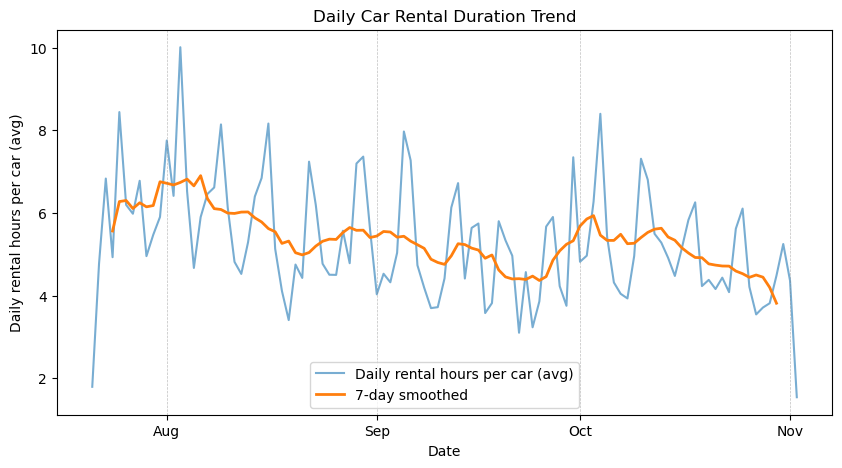

In [31]:
import matplotlib.dates as mdates

daily_use = daily_use.sort_values('date')

daily_use['rental_smooth'] = daily_use['av_rent_hour_per_car'].rolling(window=7, center=True).mean()

# Plot
plt.figure(figsize=(10,5))
plt.plot(daily_use['date'], daily_use['av_rent_hour_per_car'], label='Daily rental hours per car (avg)', alpha=0.6)
plt.plot(daily_use['date'], daily_use['rental_smooth'], label='7-day smoothed', linewidth=2)

# Format x-axis to show months
ax = plt.gca()

for d in pd.date_range(daily_use['date'].min(), daily_use['date'].max(), freq='MS'):
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())       # one tick per month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # short month name, e.g. Jan, Feb

plt.xlabel('Date')
plt.ylabel('Daily rental hours per car (avg)')
plt.title('Daily Car Rental Duration Trend')
plt.legend()
plt.show()

### Check for outliers

In [36]:
max_individual_trip = movement_df['move_duration'].max()
print('Max individual trip:', max_individual_trip)

Max individual trip: 90 days 09:09:08


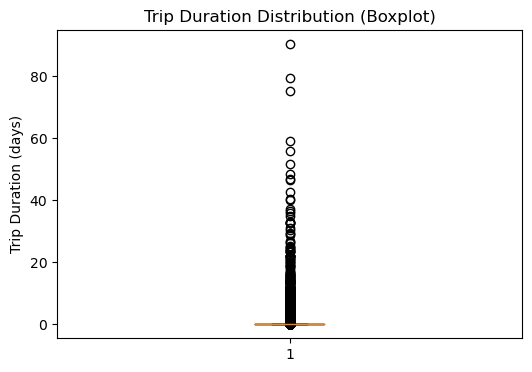

In [43]:
movement_df['move_duration_days'] = movement_df['move_duration'].dt.total_seconds() / 3600 / 24

plt.figure(figsize=(6, 4))
plt.boxplot(movement_df['move_duration_days'], vert=True)
plt.ylabel('Trip Duration (days)')
plt.title('Trip Duration Distribution (Boxplot)')
plt.show()

In [47]:
one_day = pd.Timedelta(days=1)
num_long_trips = (movement_df['move_duration'] > one_day).sum()

print("Number of trips > 1 day:", num_long_trips)
print('Proportion trips >1day: ', num_long_trips/len(movement_df))

unique_plates = movement_df.loc[
    movement_df['move_duration'] > one_day, 'licencePlate'
].nunique()
print("Unique licence plates with rental > 1 day:", unique_plates)

Number of trips > 1 day: 4318
Proportion trips >1day:  0.011197668146549936
Unique licence plates with rental > 1 day: 1243


#### Filter the >1 day trips

In [82]:
movement_df_filtered.head(2)

,licencePlate,start_move_time,end_move_time,start_lat,start_lon,end_lat,end_lon,start_zip,end_zip,start_fuel,end_fuel,move_duration,fuel_used,vehicleTypeId,rental_minutes,date,move_duration_min,move_duration_hours,move_duration_days,day_of_month
0,bn32098,2025-07-22 09:13:29,2025-07-22 09:17:29,55.658398,12.514628,55.658348,12.515684,2500.0,2500.0,72,73.0,0 days 00:04:00,-1.0,2,4.0,2025-07-22,4.0,0.066667,0.002778,22
1,bn32098,2025-07-22 09:19:29,2025-07-22 09:23:29,55.658348,12.515684,55.659286,12.519309,2500.0,1805.0,73,72.0,0 days 00:04:00,1.0,2,4.0,2025-07-22,4.0,0.066667,0.002778,22


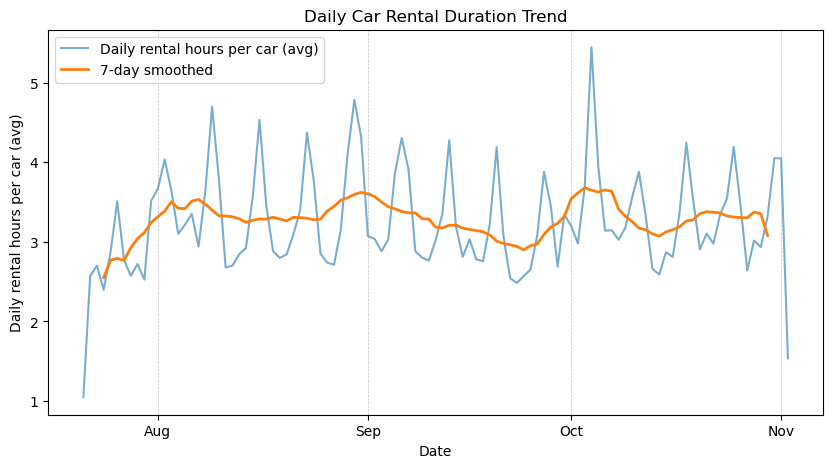

In [48]:
movement_df_filtered = movement_df[movement_df['move_duration'] <= one_day].copy()

daily_use_filtered = movement_df_filtered.groupby('date')['rental_minutes'].sum().reset_index()
daily_use_filtered['total_hours'] = daily_use_filtered['rental_minutes'] / 60
daily_use_filtered['av_rent_hour_per_car'] = daily_use_filtered['total_hours'] / n_cars

daily_use_filtered = daily_use_filtered.sort_values('date')

daily_use_filtered['rental_smooth'] = daily_use_filtered['av_rent_hour_per_car'].rolling(window=7, center=True).mean()

# Plot
plt.figure(figsize=(10,5))
plt.plot(daily_use_filtered['date'], daily_use_filtered['av_rent_hour_per_car'], label='Daily rental hours per car (avg)', alpha=0.6)
plt.plot(daily_use_filtered['date'], daily_use_filtered['rental_smooth'], label='7-day smoothed', linewidth=2)

ax = plt.gca()
for d in pd.date_range(daily_use_filtered['date'].min(), daily_use_filtered['date'].max(), freq='MS'):
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())       
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  

plt.xlabel('Date')
plt.ylabel('Daily rental hours per car (avg)')
plt.title('Daily Car Rental Duration Trend')
plt.legend()
plt.show() 

### Aggregating by day of the month (only August, September, October)

In [52]:
full_months = ['2025-08', '2025-09', '2025-10']  

movement_df_3m = movement_df_filtered[
    movement_df_filtered['date'].dt.to_period('M').astype(str).isin(full_months)
].copy()


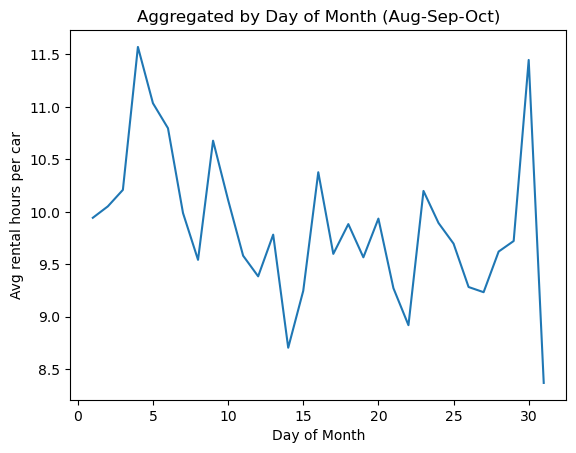

In [54]:
movement_df_3m['day_of_month'] = movement_df_3m['date'].dt.day

dom_pattern = (
    movement_df_3m.groupby('day_of_month')['rental_minutes'].sum()
    / 60 / n_cars
)

plt.plot(dom_pattern.index, dom_pattern.values)
plt.xlabel("Day of Month")
plt.ylabel("Avg rental hours per car")
plt.title("Aggregated by Day of Month (Aug-Sep-Oct)")
plt.show()

#### Agreggating by day of the week

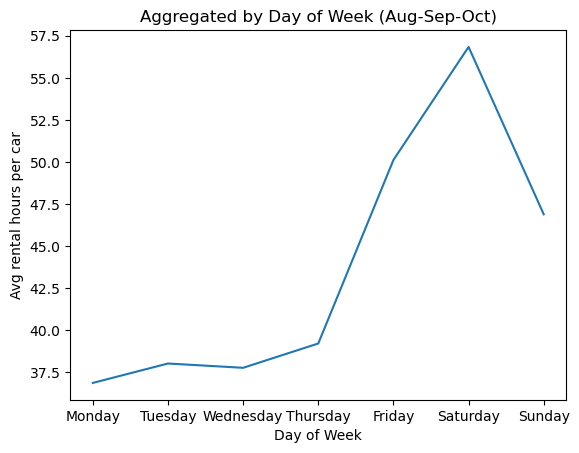

In [57]:
movement_df_3m['day_of_week'] = movement_df_3m['date'].dt.day_name()

dow_pattern = (
    movement_df_3m.groupby('day_of_week')['rental_minutes'].sum()
    / 60 / n_cars 
)

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_pattern = dow_pattern.reindex(dow_order)

plt.plot(dow_pattern.index, dow_pattern.values)
plt.xlabel("Day of Week")
plt.ylabel("Avg rental hours per car")
plt.title("Aggregated by Day of Week (Aug-Sep-Oct)")
plt.show()

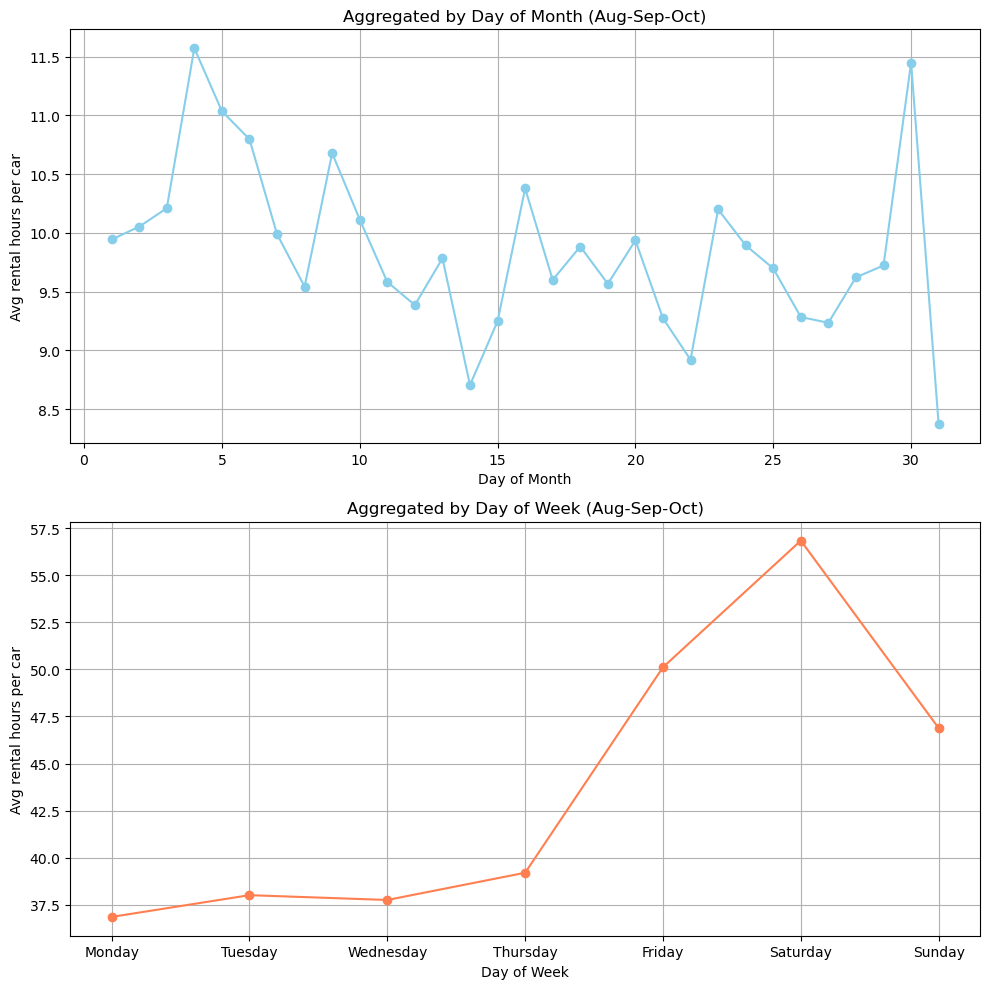

In [58]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

axes[0].plot(dom_pattern.index, dom_pattern.values, marker='o', color='skyblue')
axes[0].set_xlabel("Day of Month")
axes[0].set_ylabel("Avg rental hours per car")
axes[0].set_title("Aggregated by Day of Month (Aug-Sep-Oct)")
axes[0].grid(True)

axes[1].plot(dow_pattern.index, dow_pattern.values, marker='o', color='coral')
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Avg rental hours per car")
axes[1].set_title("Aggregated by Day of Week (Aug-Sep-Oct)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Decomposition

In [59]:
daily_use = daily_use_filtered

In [64]:
daily_use.head(1)

,rental_minutes,total_hours,av_rent_hour_per_car,rental_smooth
date,,,,
2025-07-21,82249.966667,1370.832778,1.048037,NaN


In [67]:
result = seasonal_decompose(
    daily_use['av_rent_hour_per_car'],
    model='additive', 
    period=7  # weekly pattern
)

In [ ]:
trend = result.trend
seasonal = result.seasonal
resid = result.resid
observed = result.observed

denoised = trend + seasonal
detrended = observed - trend 

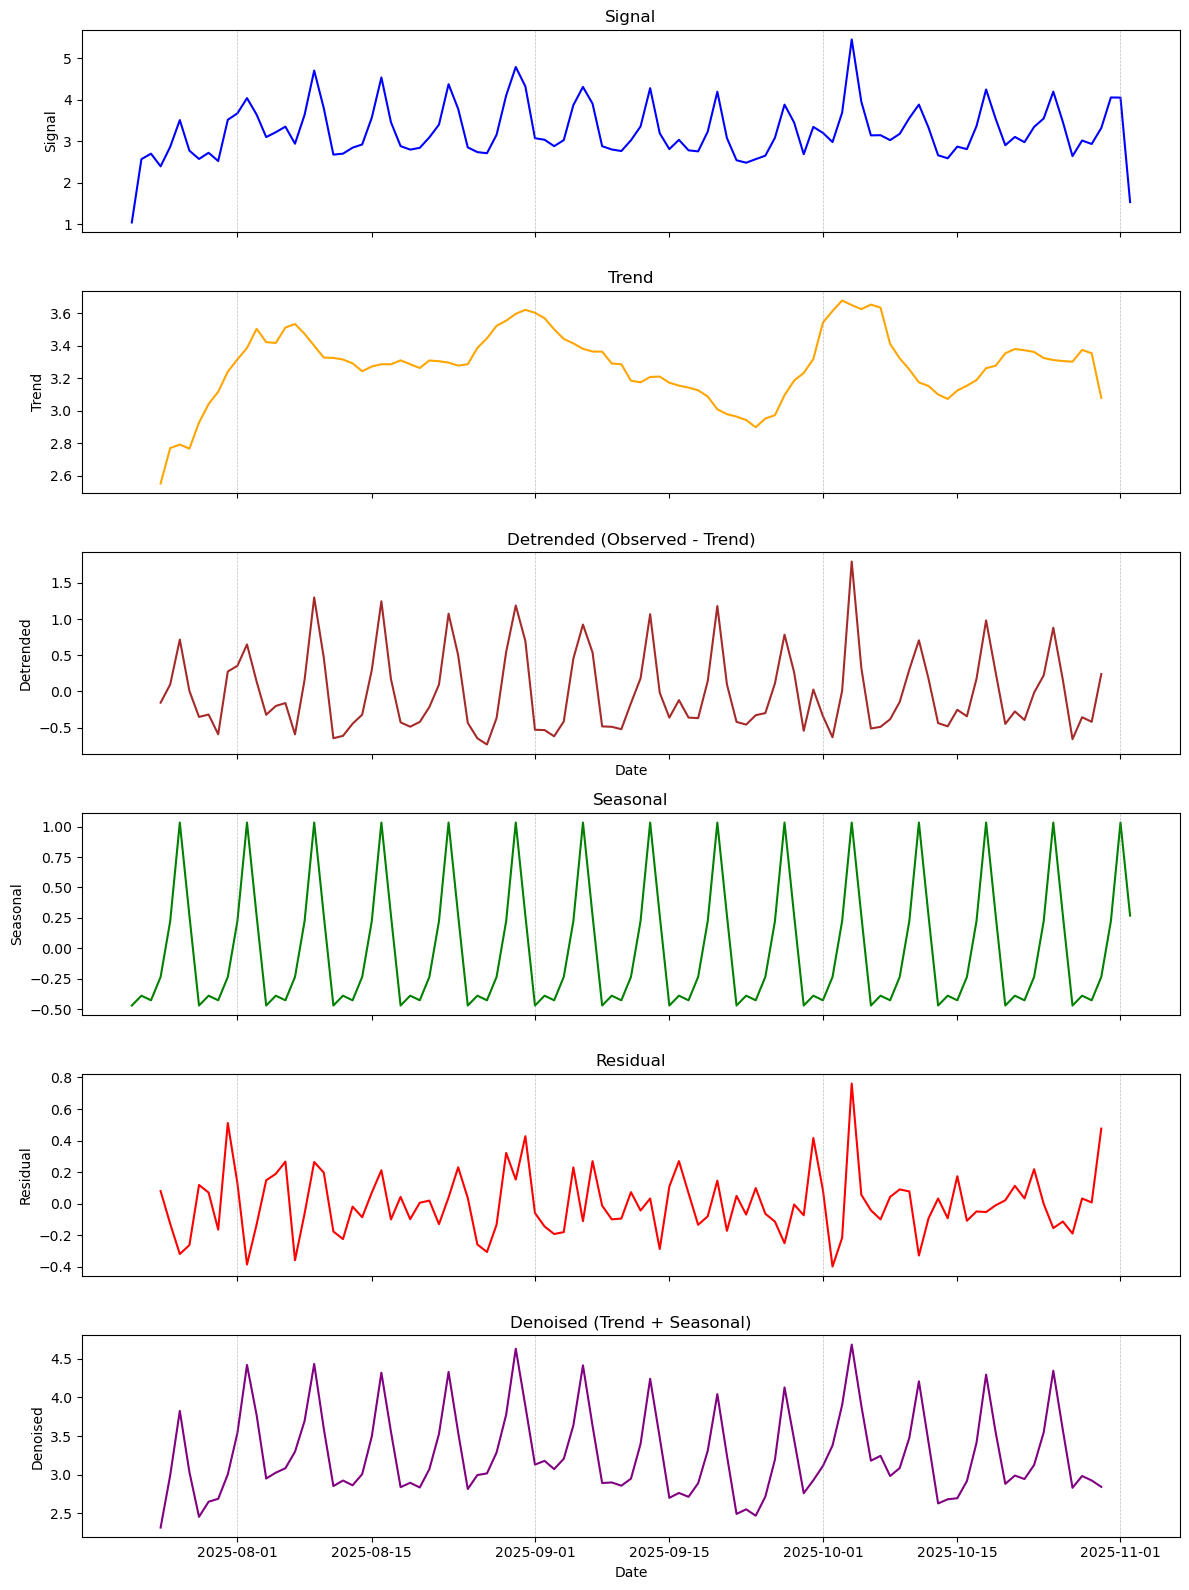

In [81]:
# Plot
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

axes[0].plot(observed.index, observed, color='blue')
axes[0].set_ylabel('Signal')
axes[0].set_title('Signal')

axes[1].plot(trend.index, trend, color='orange')
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend')

axes[2].plot(detrended.index, detrended, color='brown')
axes[2].set_ylabel('Detrended')
axes[2].set_title('Detrended (Observed - Trend)')
axes[2].set_xlabel('Date')

axes[3].plot(seasonal.index, seasonal, color='green')
axes[3].set_ylabel('Seasonal')
axes[3].set_title('Seasonal')

axes[4].plot(resid.index, resid, color='red')
axes[4].set_ylabel('Residual')
axes[4].set_title('Residual')

axes[5].plot(denoised.index, denoised, color='purple')
axes[5].set_ylabel('Denoised')
axes[5].set_title('Denoised (Trend + Seasonal)')
axes[5].set_xlabel('Date')

first_days = pd.date_range(start=observed.index.min(), end=observed.index.max(), freq='MS')
for ax in axes:
    for d in first_days:
        ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()


## Comparison cars vs vans

In [83]:
movement_df_filtered.head(2)

,licencePlate,start_move_time,end_move_time,start_lat,start_lon,end_lat,end_lon,start_zip,end_zip,start_fuel,end_fuel,move_duration,fuel_used,vehicleTypeId,rental_minutes,date,move_duration_min,move_duration_hours,move_duration_days,day_of_month
0,bn32098,2025-07-22 09:13:29,2025-07-22 09:17:29,55.658398,12.514628,55.658348,12.515684,2500.0,2500.0,72,73.0,0 days 00:04:00,-1.0,2,4.0,2025-07-22,4.0,0.066667,0.002778,22
1,bn32098,2025-07-22 09:19:29,2025-07-22 09:23:29,55.658348,12.515684,55.659286,12.519309,2500.0,1805.0,73,72.0,0 days 00:04:00,1.0,2,4.0,2025-07-22,4.0,0.066667,0.002778,22


In [84]:
vehicle_info = {
"1": {"model":"Renault Zoe","type":"car"},
"2": {"model":"Renault Zoe","type":"car"},
"6": {"model":"unknown","type":"van"},
"9":  {"model":"Renault Zoe","type":"car"},
"10": {"model":"Renault Zoe","type":"car"},
"14": {"model":"Renault Zoe","type":"car"},
"25": {"model":"unknown","type":"van"},
"26": {"model":"Renault Zoe","type":"car"},
"31": {"model":"unknown","type":"van"},
"32": {"model":"SAIC Motor MAXUS E-Deliver 3","type":"van"},
"34": {"model":"Renault Zoe","type":"car"},
"35": {"model":"Renault Zoe","type":"car"},
"57": {"model":"Renault Zoe","type":"car"},
"64": {"model":"Renault Zoe","type":"car"},
"74": {"model":"unknown","type":"van"},
"76": {"model":"Mercedes eVito","type":"van"},
"77": {"model":"Renault Zoe","type":"car"},
"79": {"model":"Peugeot e-Partner","type":"van"},
"86": {"model":"Renault Zoe","type":"car"},
"91": {"model":"Renault Zoe","type":"car"},
"94": {"model":"Renault Zoe","type":"car"},
"95": {"model":"Renault Kangoo","type":"van"},
"96": {"model":"Renault Zoe","type":"car"},
"97": {"model":"Renault Zoe","type":"car"},
"99": {"model":"Renault Zoe","type":"car"},
"102": {"model":"Renault Megane","type":"car"},
"103": {"model":"Opel Vivaro Electric","type":"van"},
"105": {"model":"Renault Zoe","type":"car"},
"106": {"model":"Renault Zoe","type":"car"},
"107": {"model":"Renault Zoe","type":"car"},
"109": {"model":"Renault Trafic E-Tech","type":"van"},
"111": {"model":"Ford E-Transit","type":"van"}
}

In [85]:
type_map = {int(k): v['type'] for k,v in vehicle_info.items()}

movement_df_filtered['vehicle_type'] = movement_df_filtered['vehicleTypeId'].map(type_map)
movement_df_filtered[['vehicleTypeId', 'vehicle_type']].head(3)

,vehicleTypeId,vehicle_type
0,2,car
1,2,car
2,2,car


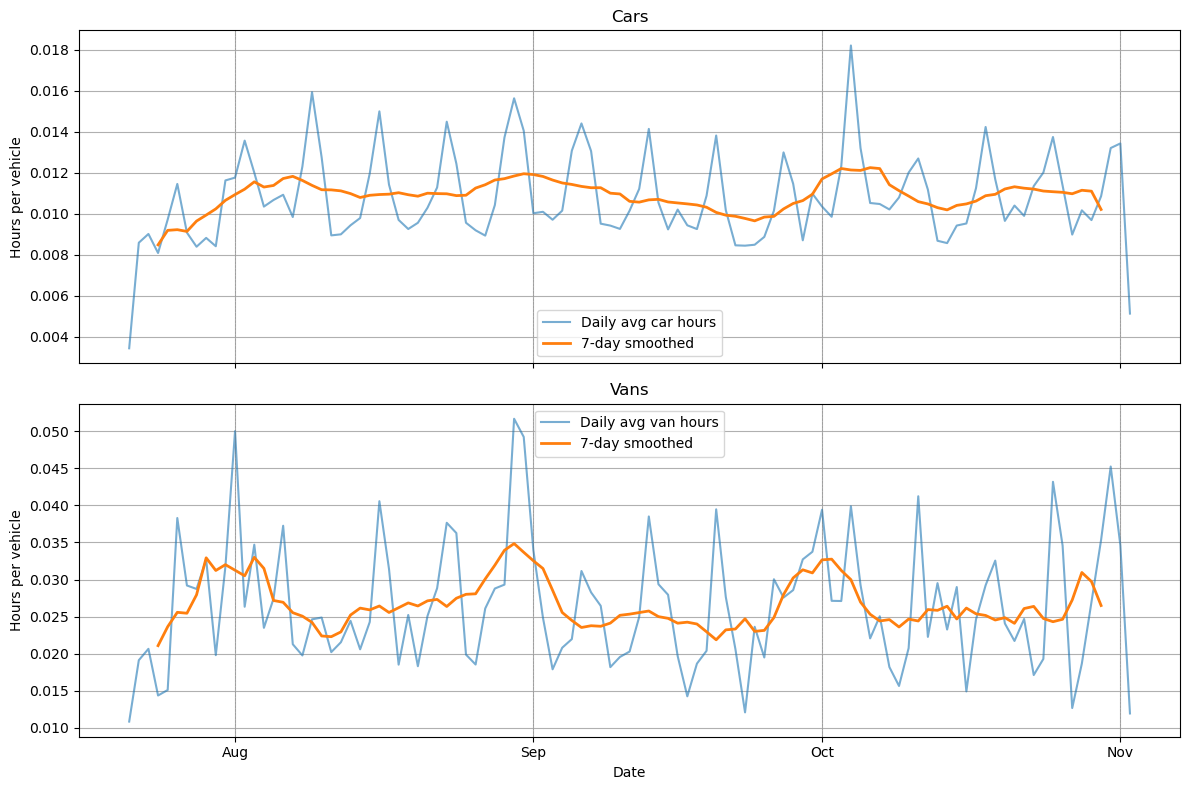

In [86]:
n_cars = (movement_df_filtered['vehicle_type'] == 'car').sum()
n_vans = (movement_df_filtered['vehicle_type'] == 'van').sum()

daily_use_type = (
    movement_df_filtered.groupby(['date','vehicle_type'])['rental_minutes']
    .sum()
    .reset_index()
)

daily_use_type['total_hours'] = daily_use_type['rental_minutes'] / 60
daily_use_type['av_rent_hour_per_vehicle'] = daily_use_type.apply(
    lambda row: row['total_hours'] / (n_cars if row['vehicle_type']=='car' else n_vans), axis=1
)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i, vtype in enumerate(['car','van']):
    df_plot = daily_use_type[daily_use_type['vehicle_type']==vtype].sort_values('date')
    df_plot['rental_smooth'] = df_plot['av_rent_hour_per_vehicle'].rolling(window=7, center=True).mean()
    
    axes[i].plot(df_plot['date'], df_plot['av_rent_hour_per_vehicle'], label=f'Daily avg {vtype} hours', alpha=0.6)
    axes[i].plot(df_plot['date'], df_plot['rental_smooth'], label='7-day smoothed', linewidth=2)
    
    for d in pd.date_range(df_plot['date'].min(), df_plot['date'].max(), freq='MS'):
        axes[i].axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    axes[i].set_ylabel('Hours per vehicle')
    axes[i].set_title(f'{vtype.capitalize()}s')
    axes[i].legend()
    axes[i].grid(True)

axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('Date')

plt.tight_layout()
plt.show()



### Day of month/week analysis - car vs van

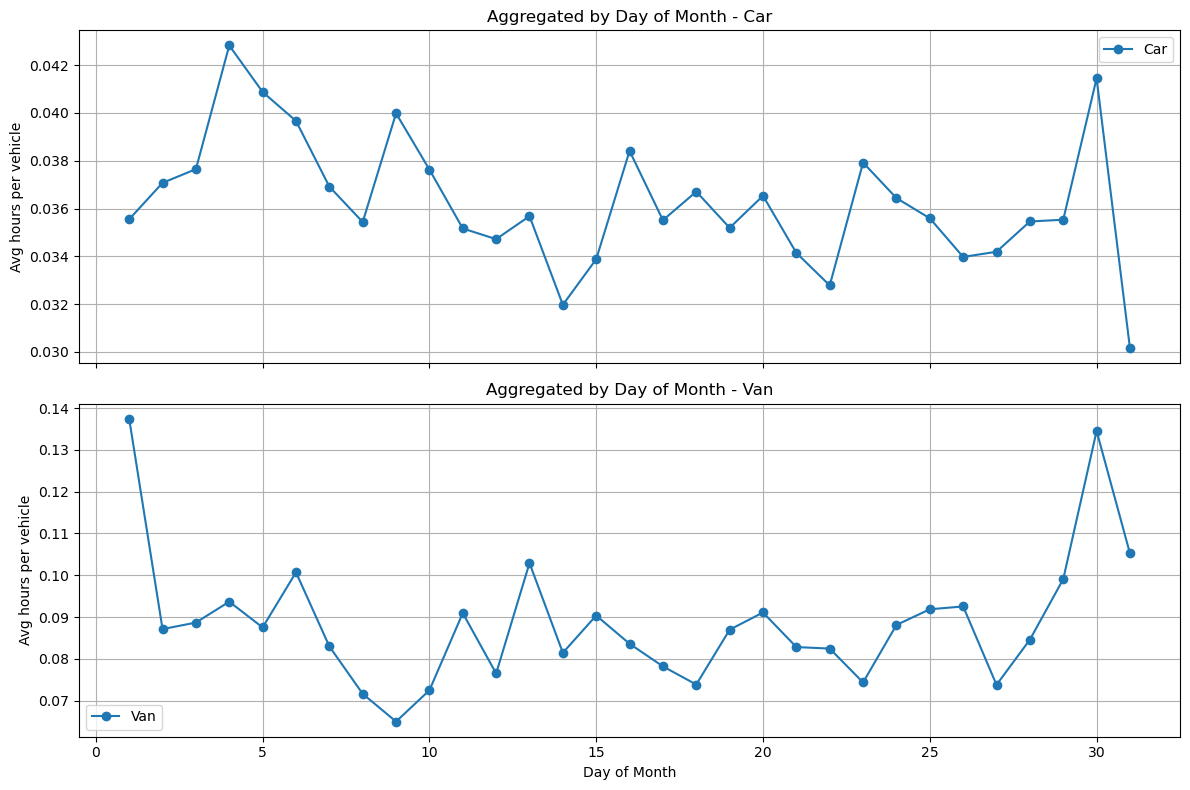

In [89]:
n_cars = (movement_df_3m['vehicle_type'] == 'car').sum()
n_vans = (movement_df_3m['vehicle_type'] == 'van').sum()

fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

for i, vtype in enumerate(['car','van']):
    df_type = movement_df_3m[movement_df_3m['vehicle_type']==vtype].copy()
    
    df_type['day_of_month'] = df_type['date'].dt.day
    
    dom_pattern = (
        df_type.groupby('day_of_month')['rental_minutes'].sum()
        / 60 / (n_cars if vtype=='car' else n_vans)
    )
    
    axes[i].plot(dom_pattern.index, dom_pattern.values, marker='o', label=vtype.capitalize())
    axes[i].set_ylabel("Avg hours per vehicle")
    axes[i].set_title(f"Aggregated by Day of Month - {vtype.capitalize()}")
    axes[i].grid(True)
    axes[i].legend()

plt.xlabel("Day of Month")
plt.tight_layout()
plt.show()


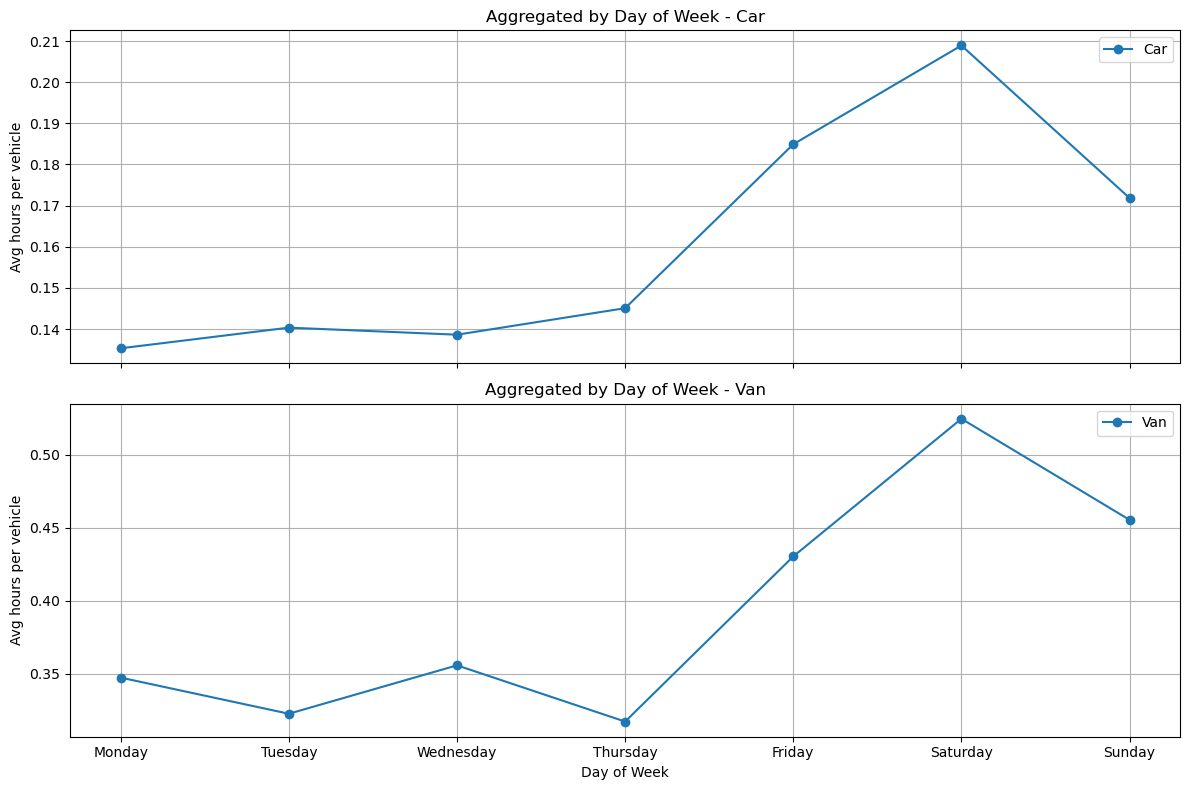

In [90]:
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, vtype in enumerate(['car','van']):
    df_type = movement_df_3m[movement_df_3m['vehicle_type']==vtype].copy()
    
    df_type['day_of_week'] = df_type['date'].dt.day_name()
    
    dow_pattern = (
        df_type.groupby('day_of_week')['rental_minutes'].sum()
        / 60 / (n_cars if vtype=='car' else n_vans)
    ).reindex(dow_order)
    
    axes[i].plot(dow_pattern.index, dow_pattern.values, marker='o', label=vtype.capitalize())
    axes[i].set_ylabel("Avg hours per vehicle")
    axes[i].set_title(f"Aggregated by Day of Week - {vtype.capitalize()}")
    axes[i].grid(True)
    axes[i].legend()

plt.xlabel("Day of Week")
plt.tight_layout()
plt.show()


### Day of the month/week analysis

### Day of the month/week analysis

____________
## Is data stationary?

(Dont think we need. Delete after)

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

In [76]:
df = daily_use.copy()
df['av_hours_log'] = np.log(df['av_rent_hour_per_car'])
df['av_hours_diff'] = df['av_rent_hour_per_car'] - df['av_rent_hour_per_car'].shift(1)
df['av_hours_return'] = df['av_rent_hour_per_car'] / df['av_rent_hour_per_car'].shift(1)
df['av_hours_return_log'] = np.log(df['av_hours_return'])
df['av_hours_log_diff'] = df['av_hours_log'] - df['av_hours_log'].shift(1)


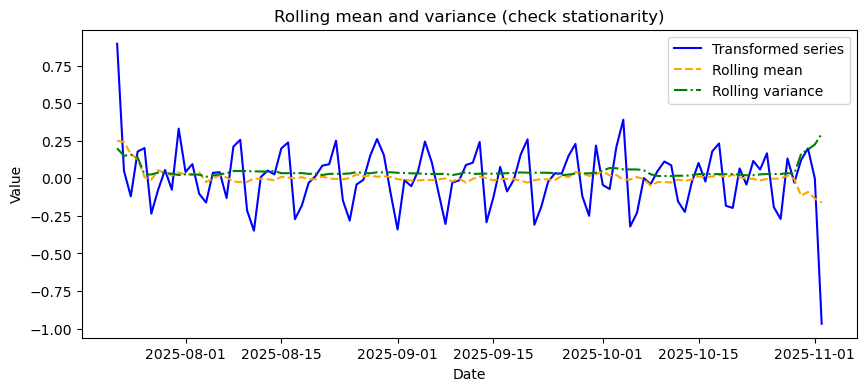

In [77]:
var = 'av_hours_log_diff'

df_plot = df[[var]].dropna()
rolling_mean = df_plot[var].rolling(window=7, min_periods=1, center=True).mean()
rolling_var = df_plot[var].rolling(window=7, min_periods=1, center=True).var()

plt.figure(figsize=(10,4))
plt.plot(df_plot.index, df_plot[var], color='blue', label='Transformed series')
plt.plot(df_plot.index, rolling_mean, '--', color='orange', label='Rolling mean')
plt.plot(df_plot.index, rolling_var, '-.', color='green', label='Rolling variance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Rolling mean and variance (check stationarity)')
plt.legend()
plt.show()


In [80]:
adf_result = adfuller(df_plot[var])
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical values:", adf_result[4])

kpss_result = kpss(df_plot[var], regression='c', nlags='auto')
print("KPSS Test Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
print("Critical values:", kpss_result[3])


ADF Test Statistic: -3.532562263675558
p-value: 0.007189163290915008
Critical values: {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
KPSS Test Statistic: 0.3791430948552877
p-value: 0.0861452177347898
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


#### Result: Series is stationary